# Regularization
This notebook compares simple linear models with complicated and overfit polynomial models and shows how regularization can prevent over-fitting by penalizing complexity.

## Generate Test Data

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
import numpy as np
np.random.seed(41)

DATA_SIZE = 30

In [2]:
# Generate linear data, get x and y into the same format
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=DATA_SIZE, n_features=1)
y = np.array([[i] for i in y])

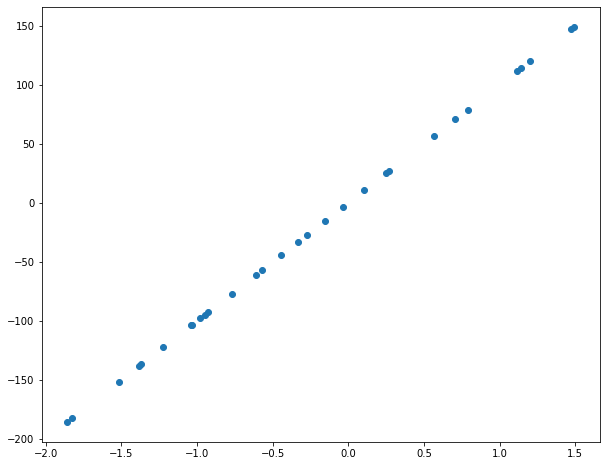

In [3]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.scatter(X, y)

In [4]:
# Add gaussian noise so that the data will resemble real-life data
mu, sigma = 0, 10 # mean and standard deviation
s = np.random.normal(mu, sigma, DATA_SIZE)
s = np.array([[i] for i in s])
y = y + s

# Min-max scale to the range [0, 1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler = MinMaxScaler()
scaler.fit(y)
y = scaler.transform(y)

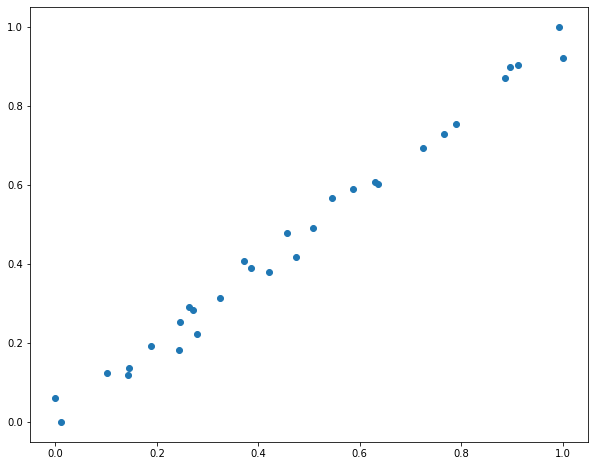

In [5]:
plt.scatter(X, y)

In [6]:
# Split the x,y data into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Create Simple Regression Models
Create two regression models: one that matches the data and one that doesn't.

In [7]:
# Simple linear regression model.
from sklearn.linear_model import LinearRegression

simple_regression = LinearRegression().fit(X_train, y_train)
simple_regression.coef_, simple_regression.intercept_ 

(array([[0.96647591]]), array([0.00495231]))

In [8]:
# Simple linear regression model with coefficients that don't fit the data well.
bad_regression = LinearRegression()
bad_regression.coef_ = np.array([[0.6]])
bad_regression.intercept_ = np.array([0.2])

In [9]:
# Simple regression: get the y-values for 0 and 1, the min and max of the data, so we can draw a line
simple_reg_y_1, simple_reg_y_2 = simple_regression.predict(np.array([[0], [1]]))
simple_reg_y_1, simple_reg_y_2

(array([0.00495231]), array([0.97142822]))

In [10]:
# Bad regression: get the y-values for 0 and 1, the min and max of the data, so we can draw a line
bad_reg_y_1, bad_reg_y_2 = bad_regression.predict(np.array([[0], [1]]))
bad_reg_y_1, bad_reg_y_2

(array([0.2]), array([0.8]))

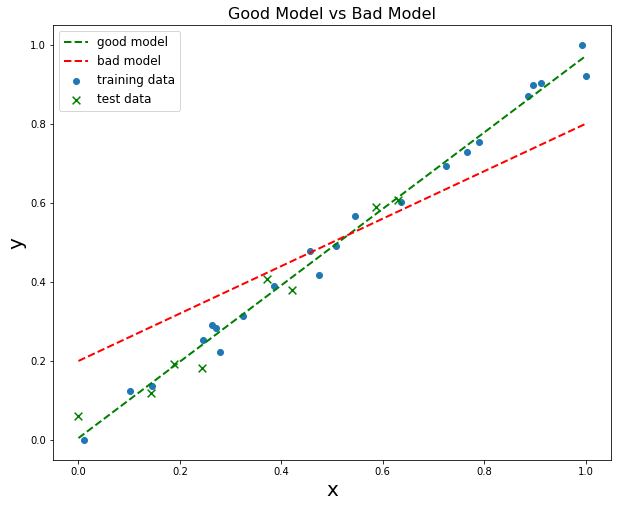

In [11]:
# Plot the good regression model vs the bad model
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('y', fontsize=20)
ax1.set_xlabel('x', fontsize=20)
ax1.set_title('Good Model vs Bad Model', fontsize=16)

plt.scatter(X_train, y_train, label="training data")
plt.scatter(X_test, y_test, label="test data", color="green", marker="x", s=60)

plt.plot([0, 1], [simple_reg_y_1, simple_reg_y_2], color='green', linestyle='dashed', linewidth=2, markersize=12, label="good model")
plt.plot([0, 1], [bad_reg_y_1, bad_reg_y_2], color='red', linestyle='dashed', linewidth=2, markersize=12, label="bad model")

plt.legend(prop={'size': 12})

## Evaluate Simple Model Error

In [12]:
# Calculate error for the good model: train and test
from sklearn.metrics import mean_squared_error

y_train_pred = simple_regression.predict(y_train)
y_test_pred = simple_regression.predict(y_test)

mean_squared_error(y_train_pred, y_train), mean_squared_error(y_test_pred, y_test)

(0.0002464711408868327, 7.580285723301916e-05)

In [13]:
# Calculate error for the bad model: train and test.
bad_y_train_pred = bad_regression.predict(y_train)
bad_y_test_pred = bad_regression.predict(y_test)

mean_squared_error(bad_y_train_pred, y_train), mean_squared_error(bad_y_test_pred, y_test)

(0.013526220469354087, 0.011556453555352338)

## Unregularized vs Regularized High-degree Polynomial Models

In [14]:
# Create a high-degree polynomial model

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(15)
x2 = poly.fit_transform(X_train)

poly_reg = LinearRegression().fit(x2, y_train)
poly_y_pred_train = poly_reg.predict(x2)
poly_reg.coef_, poly_reg.intercept_ 

(array([[ 0.00000000e+00, -1.54232528e+03,  5.21543490e+04,
         -8.66681275e+05,  8.66885548e+06, -5.74314681e+07,
          2.65852979e+08, -8.87443411e+08,  2.17441599e+09,
         -3.93894519e+09,  5.26230234e+09, -5.11555007e+09,
          3.51646106e+09, -1.61905625e+09,  4.47748476e+08,
         -5.62072498e+07]]),
 array([11.49026968]))

In [15]:
# Generate lots of points in order to plot the polynomial
xx = np.linspace(0,1,500)
qx = np.array([[i] for i in xx])
qx = poly.fit_transform(qx)
qy = poly_reg.predict(qx)

# Filter so that the polynomial doesn't go off the graph.
qq = []
for i in qy:
    if i <= 1 and i >= 0:
        qq.append(i[0])
    else:
        qq.append(0)
qq = np.array(qq)

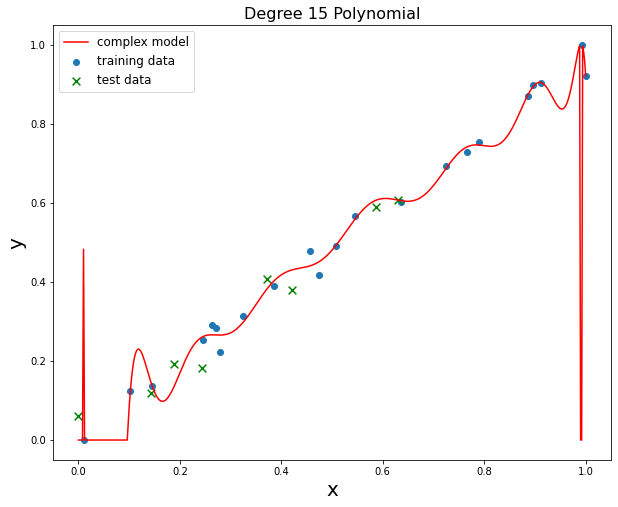

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_ylabel('y', fontsize=20)
ax1.set_xlabel('x', fontsize=20)
ax1.set_title('Degree 15 Polynomial', fontsize=16)

plt.plot(xx, qq, color='red', label="complex model")
plt.scatter(X_train, y_train, label="training data")
plt.scatter(X_test, y_test, color="green", marker="x", label="test data", s=60)

plt.legend(prop={'size': 12})

In [17]:
# Calculate error for high degree polynomial. Notive that the training error is very low, but the test data is very high.
poly_y_pred_train = poly_reg.predict(poly.fit_transform(X_train))
poly_y_pred_test = poly_reg.predict(poly.fit_transform(X_test))

mean_squared_error(poly_y_pred_train, y_train), mean_squared_error(poly_y_pred_test, y_test)

(0.00028873468366607326, 16.332471843368655)

In [18]:
# Regularize the polynomial model.
from sklearn.linear_model import Ridge

poly_2 = PolynomialFeatures(15)
x2_2 = poly_2.fit_transform(X_train)
poly_reg_2 = Ridge(alpha=0.1).fit(x2_2, y_train)

poly_y_pred_train = poly_reg_2.predict(poly.fit_transform(X_train))
poly_y_pred_test = poly_reg_2.predict(poly.fit_transform(X_test))
poly_reg_2.coef_, poly_reg_2.intercept_

(array([[ 0.        ,  0.57808413,  0.27179218,  0.10978695,  0.03564501,
          0.00392974, -0.00834946, -0.01216269, -0.01264884, -0.01215855,
         -0.01171228, -0.01170147, -0.01222754, -0.01326584, -0.01474402,
         -0.01657848]]),
 array([0.08639856]))

In [19]:
poly_reg.coef_, poly_reg_2.intercept_

(array([[ 0.00000000e+00, -1.54232528e+03,  5.21543490e+04,
         -8.66681275e+05,  8.66885548e+06, -5.74314681e+07,
          2.65852979e+08, -8.87443411e+08,  2.17441599e+09,
         -3.93894519e+09,  5.26230234e+09, -5.11555007e+09,
          3.51646106e+09, -1.61905625e+09,  4.47748476e+08,
         -5.62072498e+07]]),
 array([0.08639856]))

In [20]:
mean_squared_error(poly_y_pred_train, y_train), mean_squared_error(poly_y_pred_test, y_test)


(0.0012828018439623211, 0.001792690441158898)

In [21]:
# Generate lots of points in order to plot the polynomial
xx = np.linspace(0,1,500)
qx = np.array([[i] for i in xx])
qx = poly.fit_transform(qx)
qy = poly_reg_2.predict(qx)

# Filter so that the polynomial doesn't go off the graph.
qq = []
for i in qy:
    if i <= 1 and i >= 0:
        qq.append(i[0])
    else:
        qq.append(0)
qq = np.array(qq)

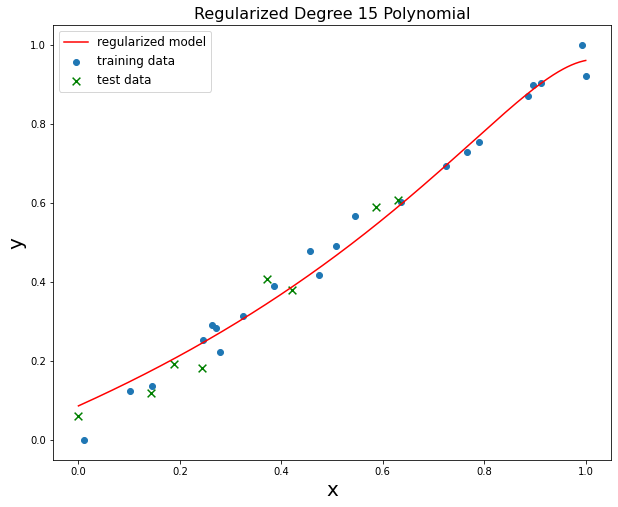

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_ylabel('y', fontsize=20)
ax1.set_xlabel('x', fontsize=20)
ax1.set_title('Regularized Degree 15 Polynomial', fontsize=16)


plt.plot(xx, qq, color='red', label="regularized model")
plt.scatter(X_train, y_train, label="training data")
plt.scatter(X_test, y_test, color="green", marker="x", label="test data", s=60)

plt.legend(prop={'size': 12})

In [23]:
# Calculate error for regularized high degree polynomial.
poly_2_y_pred_train = poly_reg_2.predict(poly.fit_transform(X_train))
poly_2_y_pred_test = poly_reg_2.predict(poly.fit_transform(X_test))

mean_squared_error(poly_2_y_pred_train, y_train), mean_squared_error(poly_2_y_pred_test, y_test)

(0.0012828018439623211, 0.001792690441158898)